In [1]:
import src.get_data as get_data
import src.load_data as load
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import datetime 

from keras.callbacks import History 
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model, save_model

import time
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8


import plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)

WINDOW = 22


Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [4]:
df = get_data.get_data_frame()

In [2]:
#  Проверим гипотезу влияния роста/подений объемов продаж на цену закрытия

def showChanging(feature):
    
    # Логарифмируем
    log_scale = np.log(feature)
    moving_avg = pd.rolling_mean(log_scale, 6)

    plt.title('Log-scale  timeseries')
    plt.plot(moving_avg, label = 'smoothing',color='red')
    plt.plot(log_scale, label = 'log-scale', color = 'blue')
    plt.legend()
    plt.show()
    
    # Цена выше нуля - volume повышается, ниже - понижается

    ts_log_diff = log_scale - log_scale.shift(-1) 
    plt.plot(ts_log_diff, color = 'green')
    plt.show()
    
    return ts_log_diff

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=6,center=False).mean()



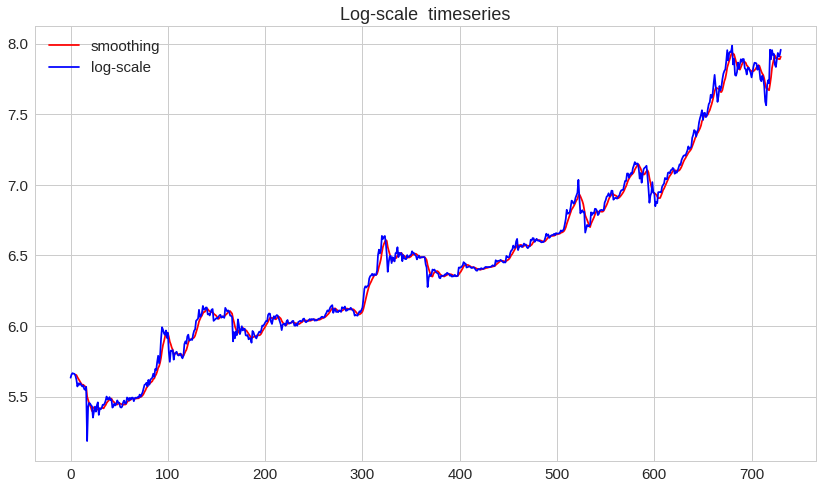

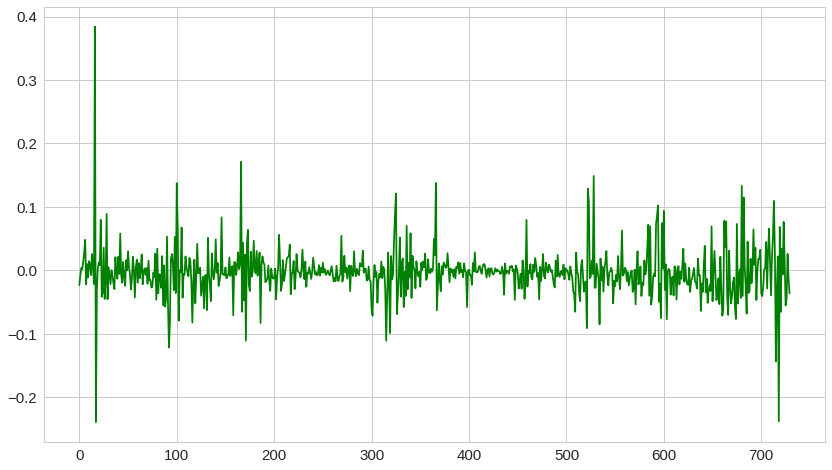

In [5]:
changingClose = showChanging(df.close)

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=6,center=False).mean()



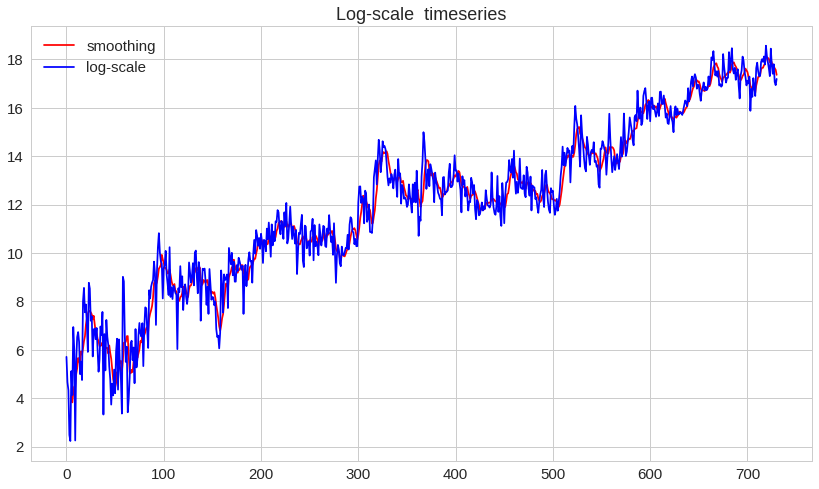

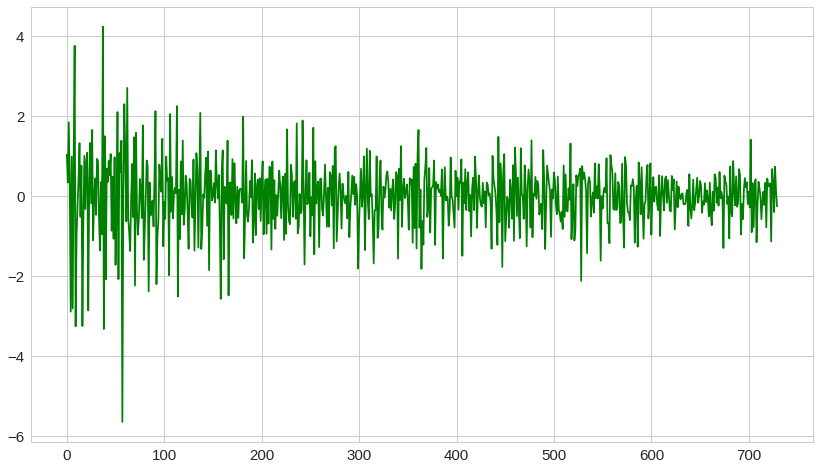

In [6]:
changingVolume = showChanging(df.volume)

In [7]:
def makeBinary(feature):
    binary = []
    for i in np.arange(1, len(feature)):
        if feature[i-1] < feature[i]:
            binary.append(1)
        else:
            binary.append(0)
    return np.array(binary)
    

In [12]:
binary_close = makeBinary(changingClose)
binary_volume = makeBinary(changingVolume)

check = np.array([binary_close==binary_volume]).astype('int')

(len(changingClose) - check.sum())/len(changingClose)

0.48974008207934339

# Variability

In [14]:
def variability(feature):
    w = 288
    
    length = int(len(feature)/w) + 1
    s = np.zeros(length)

    for j in np.arange (1,length+ 1 ):
        
        d = feature[j*w - w: j * w]

        for i in np.arange(1, d.shape[0]):
            s[j-1] += np.abs(d[i] - d[i-1])

    return s

In [91]:
from dateutil import parser
dt = parser.parse(b.index[0])

In [93]:
df = pd.read_csv('../../data/5_minutes_dump.csv')
df.columns = ['open', 'close','low', 'high', 'volume', 'date_time', 'ex', 'typeBlockchain']
splitted = pd.DataFrame(df.date_time.str.split(' ',1).tolist(),
                                   columns = ['date','time'])

df = df.join(splitted.date)
df.index = df.date_time

df = df.sort_index()
df = df[df.index != df.index[1]]

computed_variability = variability(df.volume.values) 
variabilityDataframe= pd.DataFrame(computed_variability.T, index=[ parser.parse(x) for  x in df.date.unique()[1:]], columns=['variability'])
variabilityDataframe.index.names = ['date']

data = get_data.get_data_frame()
data.index = data.date

In [98]:
data.corr()

,open,close,low,high,volume
open,1.000000,0.996965,0.997121,0.998406,0.814281
close,0.996965,1.000000,0.998244,0.998433,0.810402
low,0.997121,0.998244,1.000000,0.996312,0.787609
high,0.998406,0.998433,0.996312,1.000000,0.827538
volume,0.814281,0.810402,0.787609,0.827538,1.000000


In [96]:
all_frame =pd.DataFrame(data.volume).join(variabilityDataframe)

In [97]:
all_frame.corr()

,volume,variability
volume,1.000000,0.852741
variability,0.852741,1.000000


/root/anaconda/lib/python3.6/site-packages/pandas/plotting/_core.py:178: UserWarning:

'colors' is being deprecated. Please use 'color'instead of 'colors'



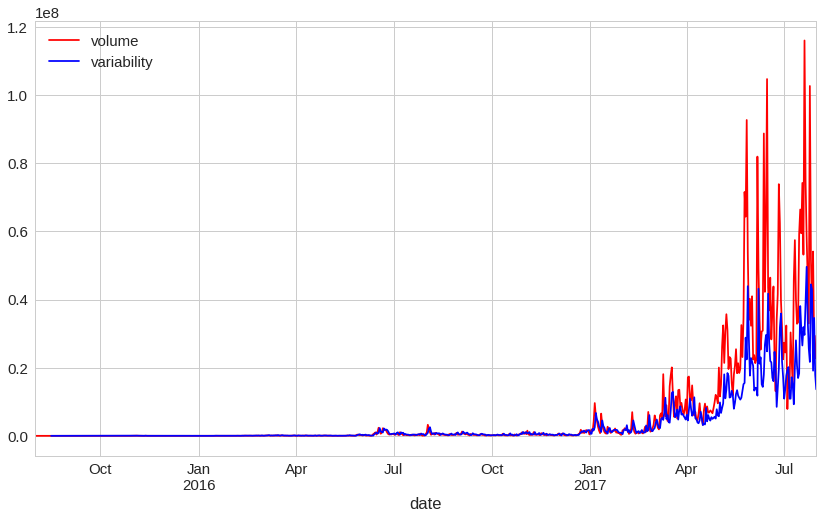

In [107]:
all_frame.plot(colors=('red', 'blue'))

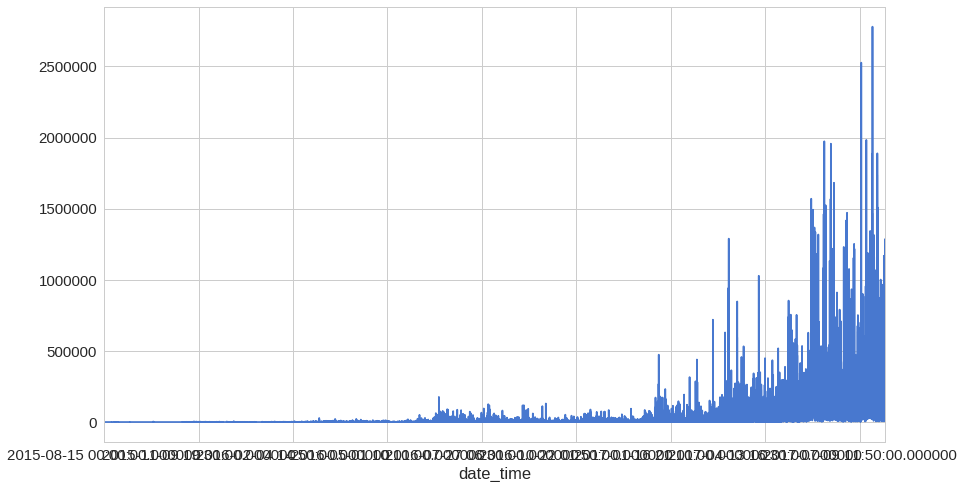

In [16]:
df.volume.plot()

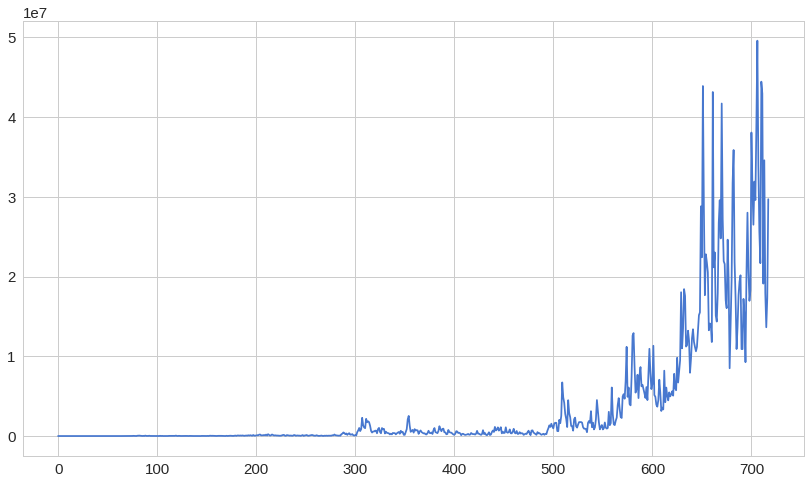

In [17]:
plt.plot(computed_variability)

In [108]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

x = x_scaler.fit_transform(data.volume.values.reshape(-1,1))
y = y_scaler.fit_transform(computed_variability.reshape(-1,1))

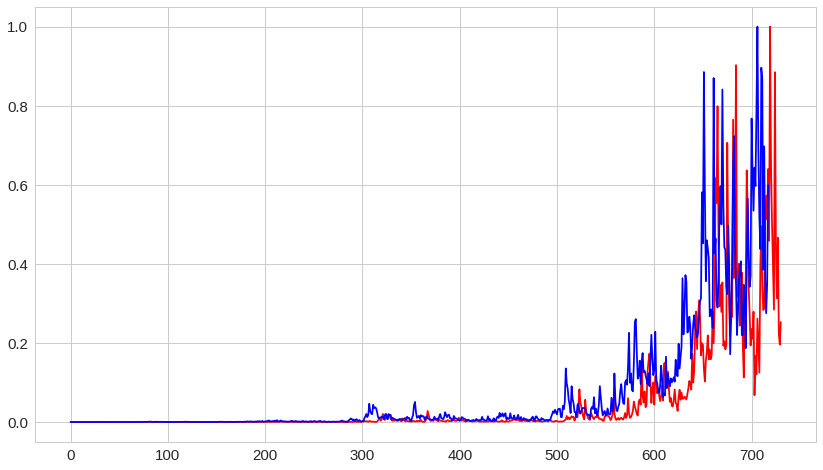

In [109]:
plt.plot(x, color = 'red')
plt.plot(y, color = 'blue')

In [ ]:

def build_model(input_shape):
    d = 0.2
    model = Sequential()
    
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(128, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="normal",activation='relu'))        
    model.add(Dense(1,kernel_initializer="normal",activation='linear'))
    
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    
    return model

In [ ]:

df = get_data.get_data_frame(typeBlockchain, stock)

#x_scaler = MinMaxScaler()
#y_scaler = MinMaxScaler()

all_df = df.copy()

x = var_volume
y = var_close

#x = pd.ewma(x,2)
#y = pd.ewma(y,2)

NUM_FEATURES = x.shape[1]

x[features] = x_scaler.fit_transform(x)
y = y_scaler.fit_transform(y.values.reshape(-1, 1))

#X_train, y_train = load.load_data(x, WINDOW, TrainTest = False)
X_train, y_train, X_test, y_test = load.load_data(x, WINDOW, train_size= 0.96, TrainTest = True)

model = build_model(input_shape=(WINDOW, NUM_FEATURES))

print('START FIT MODEL...')

start = time.time()

In [9]:


history = History()
history= model.fit(X_train, y_train, validation_data=(X_test, y_test),  batch_size=32, epochs=500,verbose=0,
          callbacks=[history])

#model.fit(X_train, y_train, batch_size=32, epochs=2, verbose=1)
end = time.time()

print ('Learning time: ', end-start)

today = time.strftime("_%d_%m_%Y")

pathModel = "../../models/model_low_high_" + typeBlockchain + today +".h5"
save_model(model, pathModel)

#model = load_model(pathModel)
# one day prediction. get last batch known data (now we didnt need in y value and can predict it)    
lastbatch = np.array(x[-WINDOW:])
pred = model.predict([lastbatch.reshape(1,22, NUM_FEATURES)])
pred =  np.array(y_scaler.inverse_transform(pred)) # predicted value

# now we make dataframe and create row names in date

lastDate =str(df.date[df.last_valid_index()]).split('-')
currentData = datetime.date(int(lastDate[0]),int(lastDate[1]),int(lastDate[2])) + datetime.timedelta(1)
predictionDate = pd.date_range(currentData, periods=1)
prediction = pd.DataFrame(pred, columns=["predictionPrice"], index = predictionDate.values)

print (prediction)


if plotForTrain:

    trainPredict = model.predict(X_train)
    trainPredict = y_scaler.inverse_transform(trainPredict)
    prices = df.close.values.astype('float32')
    prices = prices.reshape(len(prices), 1)
    trainPredictPlot = np.empty_like(prices)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[WINDOW:len(trainPredict)+WINDOW, :] = trainPredict
    Actual = pd.DataFrame(prices, columns=["close"], index=df.index).close
    Training = pd.DataFrame(trainPredictPlot, columns=["close"], index=df.date).close
    ActualValues = go.Scatter( x = df.date, y = Actual, name = 'ActualValues')
    TrainingValues = go.Scatter( x = df.date, y = Training, name = 'TrainingValues')

    iplot([ActualValues,TrainingValues])
    plt.show()

if plot:
    trainPredict = model.predict(X_train)
    testPredict = model.predict(X_test)

    trainPredict = y_scaler.inverse_transform(trainPredict)
    trainY = y_scaler.inverse_transform([y_train])

    testPredict = y_scaler.inverse_transform(testPredict)
    testY = y_scaler.inverse_transform([y_test])

    trainScore = metrics.mean_squared_error(trainY[0], trainPredict[:,0]) ** .5
    print('Train Score: %.2f RMSE' % (trainScore))

    testScore = metrics.mean_squared_error(testY[0], testPredict[:,0]) ** .5
    print('Test Score: %.2f RMSE' % (testScore))
    prices = df.close.values.astype('float32')
    prices = prices.reshape(len(prices), 1)
    trainPredictPlot = np.empty_like(prices)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[WINDOW:len(trainPredict)+WINDOW, :] = trainPredict

    testPredictPlot = np.empty_like(prices)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[(len(prices) - testPredict.shape[0]):len(prices), :] = testPredict

    plt.plot(pd.DataFrame(prices, columns=["close"], index=df.index).close, label='Actual')
    plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"], index=df.index).close, label='Training')
    plt.plot(pd.DataFrame(testPredictPlot, columns=["close"], index=df.index).close, label='Testing')
    plt.legend(loc='best')
    plt.show()

    interactiveGrapth = 1
    if interactiveGrapth:

        Actual = pd.DataFrame(prices, columns=["close"], index=df.index).close
        Training = pd.DataFrame(trainPredictPlot, columns=["close"], index=df.date).close
        Testing = pd.DataFrame(testPredictPlot, columns=["close"], index=df.date).close

        ActualValues = go.Scatter( x = df.date, y = Actual, name = 'ActualValues')
        TrainingValues = go.Scatter( x = df.date, y = Training, name = 'TrainingValues')
        TestingValues = go.Scatter( x = df.date, y = Testing, name = 'PredictedValues')

        iplot([ActualValues,TrainingValues, TestingValues])
        plt.show()

    if plotHictory:

        plt.plot(history.history['loss'], label = 'TrainLoss')
        plt.plot(history.history['val_loss'], label = 'TestLoss')
        plt.legend()
        plt.show()

return prediction

In [ ]:
USDT_BTC = nextDayPrediction('USDT_BTC', 'poloniex' )

START FIT MODEL...


/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning:

pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(com=2,min_periods=0,adjust=True,ignore_na=False).mean()

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning:

pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(com=2,min_periods=0,adjust=True,ignore_na=False).mean()



START FIT MODEL...
Learning time:  406.8902087211609
            predictionPrice
2017-07-28        40.004932
Train Score: 0.29 RMSE
Test Score: 3.97 RMSE


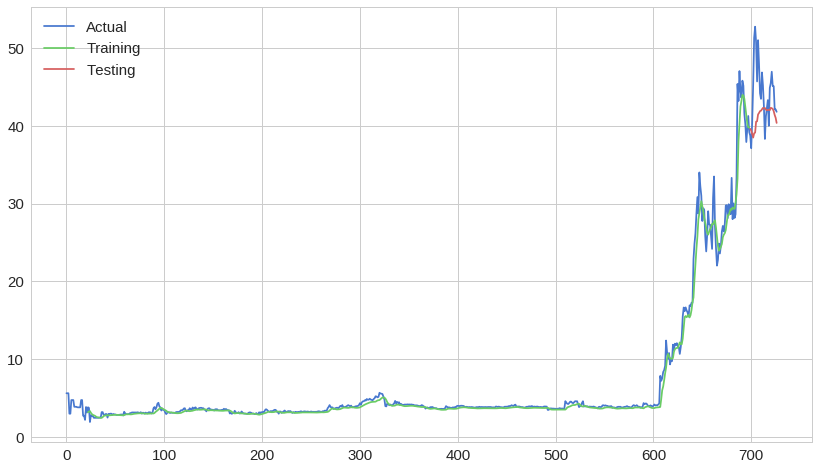

In [18]:
USDT_LTC = nextDayPrediction('USDT_LTC', 'poloniex')

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning:

pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(com=2,min_periods=0,adjust=True,ignore_na=False).mean()

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning:

pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(com=2,min_periods=0,adjust=True,ignore_na=False).mean()



START FIT MODEL...
Learning time:  388.0152406692505
            predictionPrice
2017-07-28       237.119736
Train Score: 2.50 RMSE
Test Score: 63.97 RMSE


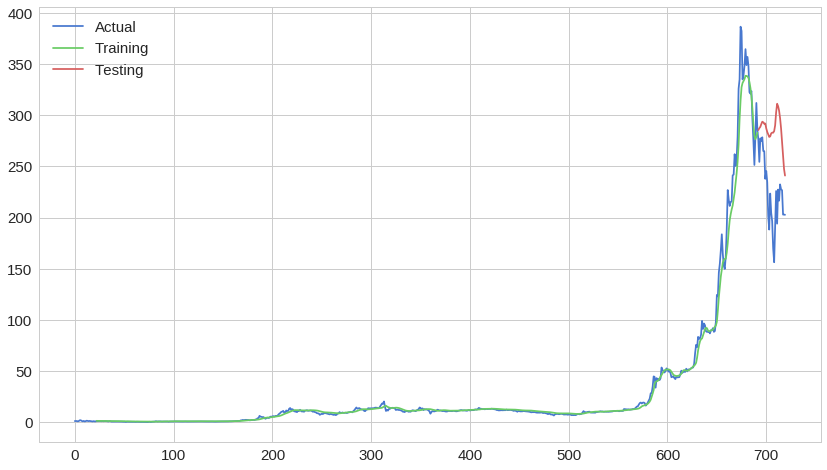

In [19]:
USDT_ETH = nextDayPrediction('USDT_ETH', 'poloniex')

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning:

pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(com=2,min_periods=0,adjust=True,ignore_na=False).mean()

/root/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning:

pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(com=2,min_periods=0,adjust=True,ignore_na=False).mean()



START FIT MODEL...
Learning time:  204.86186575889587
            predictionPrice
2017-07-28        16.494059
Train Score: 0.20 RMSE
Test Score: 1.29 RMSE


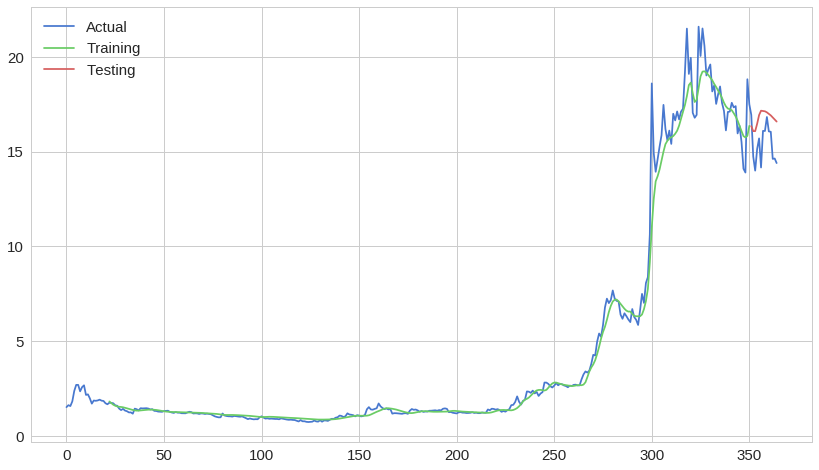

In [20]:
USDT_ETC = nextDayPrediction('USDT_ETC', 'poloniex')

In [ ]:
USDT_XRP = nextDayPrediction('USDT_XRP', 'poloniex',N = 1)

In [86]:
print ('predictionValues on', datetime.date.today())

allCurrency = ['USDT_BTC', 'USDT_LTC', 'USDT_ETH', 'USDT_ETC', 'USDT_XRP']
predictedValues = [USDT_BTC, USDT_LTC, USDT_ETH, USDT_ETC, USDT_XRP]

for index in np.arange(len(allCurrency)):
    print(allCurrency[index], '\n' , predictedValues[index] )


predictionValues on 2017-07-26
USDT_BTC 
             predictionPrice
2017-07-26      2545.130371
USDT_LTC 
             predictionPrice
2017-07-26        42.890644
USDT_ETH 
             predictionPrice
2017-07-26       193.827957
USDT_ETC 
             predictionPrice
2017-07-26        14.239629
USDT_XRP 
             predictionPrice
2017-07-26         0.177823


In [63]:
def checkTrend(typeBlockchain, stock, predicted):
    
    df = get_data_frame(typeBlockchain, stock)
    lastValue = df.close[df.shape[0]-1]
    change = (predicted.values * 100 / lastValue) - 100
    if change > 0:
        mark = 'PositiveTrend'
    else: mark = 'NegativeTrend'
        
    print ('-'*10 + '\nSTOCK:%s, type:%s\n'%(stock, typeBlockchain))
    print ('Change between last (%f) and predicted values(%f) = %f perc.\n%s' \
           % (lastValue, predicted.values, change, mark))

In [84]:
stock = 'poloniex'

for index in np.arange(len(allCurrency)):
    checkTrend(allCurrency[index], stock , predictedValues[index] )

----------
STOCK:poloniex, type:USDT_BTC

Change between last (2565.999999) and predicted values(2545.130371) = -0.813316 perc.
NegativeTrend
----------
STOCK:poloniex, type:USDT_LTC

Change between last (42.110000) and predicted values(42.890644) = 1.853821 perc.
PositiveTrend
----------
STOCK:poloniex, type:USDT_ETH

Change between last (203.000000) and predicted values(193.827957) = -4.518250 perc.
NegativeTrend
----------
STOCK:poloniex, type:USDT_ETC

Change between last (14.620000) and predicted values(14.239629) = -2.601715 perc.
NegativeTrend
----------
STOCK:poloniex, type:USDT_XRP

Change between last (0.174540) and predicted values(0.177823) = 1.881226 perc.
PositiveTrend
